# Dog Breed Classification with Transfer Learning

This notebook implements a dog breed classifier using transfer learning with pretrained CNN models.

**Objective:** Achieve >90% accuracy on the Stanford Dogs dataset (93 classes)

**Models:**
- ResNet50 (main model)
- ResNet50 with full training (for powerful GPU)

## 1. Setup and Imports

In [1]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    DATASET_PATH = '/content/drive/MyDrive/AI1_DogbreedClassifier/Dataset'
except:
    IN_COLAB = False
    DATASET_PATH = './Dataset'  # Local path

print(f"Running in Colab: {IN_COLAB}")
print(f"Dataset path: {DATASET_PATH}")

Mounted at /content/drive
Running in Colab: True
Dataset path: /content/drive/MyDrive/AI1_DogbreedClassifier/Dataset


In [2]:
# Standard libraries
import os
import numpy as np
import random
from PIL import Image
import time
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Progress bar
from tqdm import tqdm

In [3]:
# Reproducibility - Set seeds for all random operations
def set_seed(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seeds set for reproducibility")

Random seeds set for reproducibility


In [4]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# Paths
CHECKPOINT_PATH = './checkpoints'
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

Using device: cuda


## 2. Data Loading and Preprocessing

In [5]:
# Calculate dataset statistics for normalization
# Using ImageNet statistics since we're using pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Using ImageNet normalization:")
print(f"Mean: {IMAGENET_MEAN}")
print(f"Std: {IMAGENET_STD}")

Using ImageNet normalization:
Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


In [6]:
# Define transforms
# Training: Data augmentation to reduce overfitting
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Validation/Test: No augmentation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print("Transforms defined")

Transforms defined


In [7]:
# Load datasets
train_path = os.path.join(DATASET_PATH, 'train')
val_path = os.path.join(DATASET_PATH, 'val')
test_path = os.path.join(DATASET_PATH, 'test')

trainset = ImageFolder(root=train_path, transform=train_transform)
valset = ImageFolder(root=val_path, transform=val_transform)
testset = ImageFolder(root=test_path, transform=val_transform)

# Get class information
num_classes = len(trainset.classes)
class_names = trainset.classes

print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(trainset)}")
print(f"Validation samples: {len(valset)}")
print(f"Test samples: {len(testset)}")

Number of classes: 93
Training samples: 6391
Validation samples: 762
Test samples: 887


In [8]:
# Create DataLoaders
batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=4, pin_memory=True, drop_last=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False,
                       num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(trainloader)}")
print(f"Validation batches: {len(valloader)}")
print(f"Test batches: {len(testloader)}")

Batch size: 32
Training batches: 199
Validation batches: 24
Test batches: 28


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


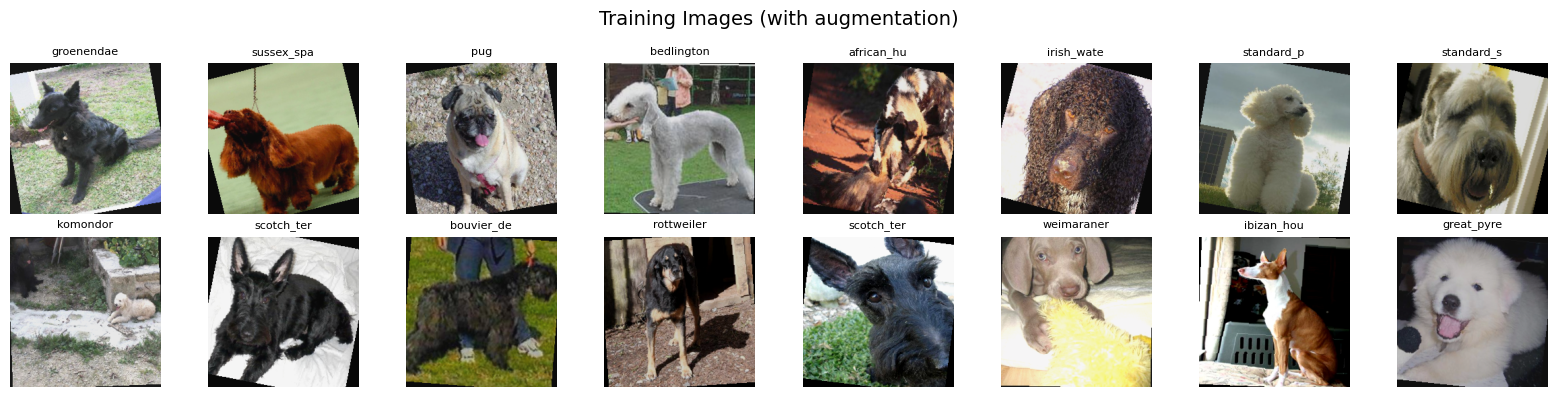

In [9]:
# Visualize sample images with augmentation
def show_batch(dataloader, title="Sample Images"):
    """Display a batch of images."""
    images, labels = next(iter(dataloader))

    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Create grid
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    fig.suptitle(title, fontsize=14)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.set_title(class_names[labels[i]][:10], fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_batch(trainloader, "Training Images (with augmentation)")

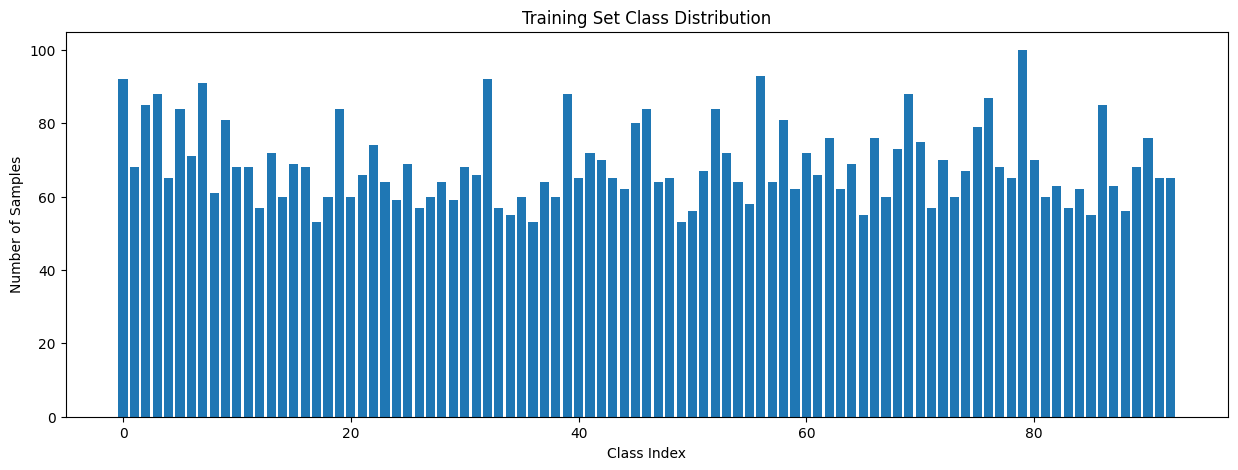

Min samples per class: 53
Max samples per class: 100
Imbalance ratio: 1.89


In [10]:
# Check class distribution
train_labels = [label for _, label in trainset.samples]
class_counts = Counter(train_labels)

plt.figure(figsize=(15, 5))
plt.bar(range(num_classes), [class_counts[i] for i in range(num_classes)])
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution')
plt.show()

print(f"Min samples per class: {min(class_counts.values())}")
print(f"Max samples per class: {max(class_counts.values())}")
print(f"Imbalance ratio: {max(class_counts.values()) / min(class_counts.values()):.2f}")

## 3. Model Definition

In [11]:
def create_resnet50_model(num_classes, freeze_backbone=True):
    """Create a ResNet50 model with custom classifier."""
    # Load pretrained ResNet50
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Freeze backbone if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Replace classifier
    num_features = model.fc.in_features  # 2048
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

    # Initialize new layers
    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

    return model

# Create model
model = create_resnet50_model(num_classes, freeze_backbone=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Total parameters: 24,604,829
Trainable parameters: 1,096,797


## 4. Training Functions

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

In [13]:
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler,
                device, num_epochs, checkpoint_path):
    """Complete training loop with checkpointing."""
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train
        train_loss, train_acc = train_epoch(model, trainloader, criterion,
                                            optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, valloader, criterion, device)

        # Update scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        elapsed = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f} | Time: {elapsed:.1f}s")

    print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
    return history, best_val_acc

## 5. Phase 1: Train Classifier Head (Frozen Backbone)

In [14]:
# Training configuration - Phase 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3)

num_epochs_phase1 = 15
checkpoint_phase1 = os.path.join(CHECKPOINT_PATH, 'resnet50_phase1.pth')

print("Phase 1: Training classifier head (backbone frozen)")
print(f"Epochs: {num_epochs_phase1}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Phase 1: Training classifier head (backbone frozen)
Epochs: 15
Learning rate: 0.001


In [15]:
# Train Phase 1
set_seed(42)  # Reset seed for reproducibility

history_phase1, best_acc_phase1 = train_model(
    model, trainloader, valloader, criterion, optimizer, scheduler,
    device, num_epochs_phase1, checkpoint_phase1
)

Epoch 1/15 | Train Loss: 2.6307, Acc: 43.58% | Val Loss: 0.5878, Acc: 85.17% | LR: 0.001000 | Time: 652.2s


Epoch 2/15 | Train Loss: 0.8901, Acc: 76.29% | Val Loss: 0.4872, Acc: 85.43% | LR: 0.001000 | Time: 62.8s


Epoch 3/15 | Train Loss: 0.6655, Acc: 82.05% | Val Loss: 0.4418, Acc: 87.14% | LR: 0.001000 | Time: 63.1s


Epoch 4/15 | Train Loss: 0.5248, Acc: 85.00% | Val Loss: 0.4274, Acc: 87.93% | LR: 0.001000 | Time: 62.6s


Epoch 5/15 | Train Loss: 0.4559, Acc: 86.76% | Val Loss: 0.4536, Acc: 87.53% | LR: 0.001000 | Time: 63.5s


Epoch 6/15 | Train Loss: 0.3772, Acc: 89.12% | Val Loss: 0.4192, Acc: 88.06% | LR: 0.001000 | Time: 63.3s


Epoch 7/15 | Train Loss: 0.3405, Acc: 89.71% | Val Loss: 0.4265, Acc: 88.85% | LR: 0.001000 | Time: 62.6s


Epoch 8/15 | Train Loss: 0.3136, Acc: 90.47% | Val Loss: 0.4351, Acc: 87.27% | LR: 0.001000 | Time: 63.5s


Epoch 9/15 | Train Loss: 0.3058, Acc: 90.47% | Val Loss: 0.3919, Acc: 89.63% | LR: 0.001000 | Time: 62.6s


Epoch 10/15 | Train Loss: 0.2595, Acc: 91.94% | Val Loss: 0.4305, Acc: 89.11% | LR: 0.001000 | Time: 62.1s


Epoch 11/15 | Train Loss: 0.2665, Acc: 91.68% | Val Loss: 0.3953, Acc: 89.76% | LR: 0.001000 | Time: 63.4s


Epoch 12/15 | Train Loss: 0.2421, Acc: 92.54% | Val Loss: 0.3924, Acc: 89.50% | LR: 0.001000 | Time: 62.0s


Epoch 13/15 | Train Loss: 0.2291, Acc: 93.09% | Val Loss: 0.4080, Acc: 88.06% | LR: 0.000500 | Time: 63.4s


Epoch 14/15 | Train Loss: 0.1795, Acc: 94.38% | Val Loss: 0.4228, Acc: 89.50% | LR: 0.000500 | Time: 61.7s


Epoch 15/15 | Train Loss: 0.1525, Acc: 95.12% | Val Loss: 0.3788, Acc: 90.16% | LR: 0.000500 | Time: 61.3s

Best Validation Accuracy: 90.16%


## 6. Phase 2: Fine-tune Entire Model

In [16]:
# Load best Phase 1 model
model.load_state_dict(torch.load(checkpoint_phase1))

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = optim.AdamW([
    {'params': model.conv1.parameters(), 'lr': 1e-5},
    {'params': model.bn1.parameters(), 'lr': 1e-5},
    {'params': model.layer1.parameters(), 'lr': 1e-5},
    {'params': model.layer2.parameters(), 'lr': 1e-5},
    {'params': model.layer3.parameters(), 'lr': 5e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 5e-4}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3)

num_epochs_phase2 = 20
checkpoint_phase2 = os.path.join(CHECKPOINT_PATH, 'resnet50_phase2_best.pth')

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nPhase 2: Fine-tuning entire model")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Epochs: {num_epochs_phase2}")


Phase 2: Fine-tuning entire model
Trainable parameters: 24,604,829
Epochs: 20


In [17]:
# Train Phase 2
history_phase2, best_acc_phase2 = train_model(
    model, trainloader, valloader, criterion, optimizer, scheduler,
    device, num_epochs_phase2, checkpoint_phase2
)

Epoch 1/20 | Train Loss: 0.1984, Acc: 93.83% | Val Loss: 0.4061, Acc: 88.85% | LR: 0.000010 | Time: 78.6s


Epoch 2/20 | Train Loss: 0.1342, Acc: 95.65% | Val Loss: 0.3872, Acc: 89.63% | LR: 0.000010 | Time: 78.5s


Epoch 3/20 | Train Loss: 0.1207, Acc: 96.22% | Val Loss: 0.4308, Acc: 88.98% | LR: 0.000010 | Time: 77.7s


Epoch 4/20 | Train Loss: 0.1016, Acc: 96.98% | Val Loss: 0.4078, Acc: 89.24% | LR: 0.000010 | Time: 79.1s


Epoch 5/20 | Train Loss: 0.0881, Acc: 97.19% | Val Loss: 0.4916, Acc: 87.14% | LR: 0.000010 | Time: 77.4s


Epoch 6/20 | Train Loss: 0.0772, Acc: 97.60% | Val Loss: 0.4751, Acc: 87.80% | LR: 0.000005 | Time: 78.8s


Epoch 7/20 | Train Loss: 0.0642, Acc: 98.10% | Val Loss: 0.4389, Acc: 89.11% | LR: 0.000005 | Time: 77.8s


Epoch 8/20 | Train Loss: 0.0402, Acc: 98.90% | Val Loss: 0.4415, Acc: 90.16% | LR: 0.000005 | Time: 78.7s


Epoch 9/20 | Train Loss: 0.0353, Acc: 98.96% | Val Loss: 0.4227, Acc: 89.90% | LR: 0.000005 | Time: 77.8s


Epoch 10/20 | Train Loss: 0.0315, Acc: 99.12% | Val Loss: 0.4369, Acc: 89.50% | LR: 0.000003 | Time: 77.9s


Epoch 11/20 | Train Loss: 0.0245, Acc: 99.28% | Val Loss: 0.4512, Acc: 89.76% | LR: 0.000003 | Time: 78.6s


Epoch 12/20 | Train Loss: 0.0249, Acc: 99.18% | Val Loss: 0.4657, Acc: 89.11% | LR: 0.000003 | Time: 77.3s


Epoch 13/20 | Train Loss: 0.0290, Acc: 99.20% | Val Loss: 0.4498, Acc: 89.50% | LR: 0.000003 | Time: 79.0s


Epoch 14/20 | Train Loss: 0.0176, Acc: 99.48% | Val Loss: 0.4407, Acc: 90.16% | LR: 0.000001 | Time: 77.1s


Epoch 15/20 | Train Loss: 0.0184, Acc: 99.42% | Val Loss: 0.4523, Acc: 89.76% | LR: 0.000001 | Time: 79.1s


Epoch 16/20 | Train Loss: 0.0143, Acc: 99.69% | Val Loss: 0.4503, Acc: 89.76% | LR: 0.000001 | Time: 77.3s


Epoch 17/20 | Train Loss: 0.0137, Acc: 99.61% | Val Loss: 0.4613, Acc: 89.11% | LR: 0.000001 | Time: 79.0s


Epoch 18/20 | Train Loss: 0.0130, Acc: 99.61% | Val Loss: 0.4590, Acc: 89.50% | LR: 0.000001 | Time: 77.3s


Epoch 19/20 | Train Loss: 0.0107, Acc: 99.73% | Val Loss: 0.4592, Acc: 89.63% | LR: 0.000001 | Time: 78.7s


Epoch 20/20 | Train Loss: 0.0118, Acc: 99.65% | Val Loss: 0.4530, Acc: 89.11% | LR: 0.000001 | Time: 78.5s

Best Validation Accuracy: 90.16%


## 7. Visualization

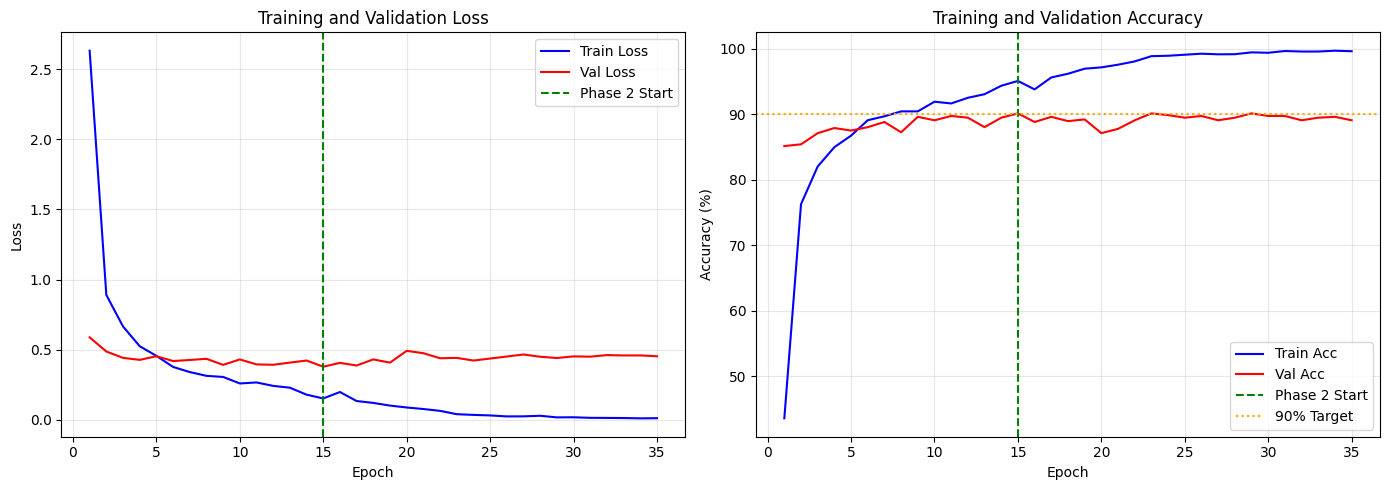

In [18]:
def plot_training_history(history_phase1, history_phase2):
    """Plot training curves for both phases."""
    # Combine histories
    train_loss = history_phase1['train_loss'] + history_phase2['train_loss']
    val_loss = history_phase1['val_loss'] + history_phase2['val_loss']
    train_acc = history_phase1['train_acc'] + history_phase2['train_acc']
    val_acc = history_phase1['val_acc'] + history_phase2['val_acc']

    epochs = range(1, len(train_loss) + 1)
    phase1_end = len(history_phase1['train_loss'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_loss, 'b-', label='Train Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Val Loss')
    ax1.axvline(x=phase1_end, color='g', linestyle='--', label='Phase 2 Start')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_acc, 'b-', label='Train Acc')
    ax2.plot(epochs, val_acc, 'r-', label='Val Acc')
    ax2.axvline(x=phase1_end, color='g', linestyle='--', label='Phase 2 Start')
    ax2.axhline(y=90, color='orange', linestyle=':', label='90% Target')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_PATH, 'training_curves.png'), dpi=150)
    plt.show()

plot_training_history(history_phase1, history_phase2)

## 8. Evaluation on Test Set

In [19]:
def evaluate_model(model, dataloader, criterion, device, class_names):
    """Comprehensive evaluation with metrics."""
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = 100.0 * np.mean(np.array(all_predictions) == np.array(all_labels))

    return test_loss, test_acc, all_predictions, all_labels

In [20]:
# Load best model and evaluate
model.load_state_dict(torch.load(checkpoint_phase2))

test_loss, test_acc, predictions, labels = evaluate_model(
    model, testloader, criterion, device, class_names
)

print(f"\n{'='*50}")
print(f"FINAL TEST RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Target: 90%")
print(f"{'='*50}")

if test_acc >= 90:
    print("TARGET ACHIEVED!")
else:
    print(f"Gap to target: {90 - test_acc:.2f}%")

Testing: 100%|██████████| 28/28 [01:29<00:00,  3.19s/it]


FINAL TEST RESULTS
Test Loss: 0.3791
Test Accuracy: 90.87%
Target: 90%
TARGET ACHIEVED!


In [21]:
# Classification Report
print("\nClassification Report:")
print("="*50)
report = classification_report(labels, predictions,
                               target_names=class_names,
                               zero_division=0)
print(report)


Classification Report:
                             precision    recall  f1-score   support

               afghan_hound       1.00      1.00      1.00        13
        african_hunting_dog       1.00      1.00      1.00        10
                   airedale       0.85      0.92      0.88        12
                    basenji       0.77      0.91      0.83        11
                     basset       1.00      1.00      1.00         9
                     beagle       0.90      0.82      0.86        11
         bedlington_terrier       0.91      1.00      0.95        10
       bernese_mountain_dog       0.92      1.00      0.96        12
    black-and-tan_coonhound       1.00      0.56      0.71         9
           blenheim_spaniel       0.90      0.82      0.86        11
                 bloodhound       0.90      1.00      0.95         9
                   bluetick       0.90      1.00      0.95         9
              border_collie       0.67      0.75      0.71         8
         

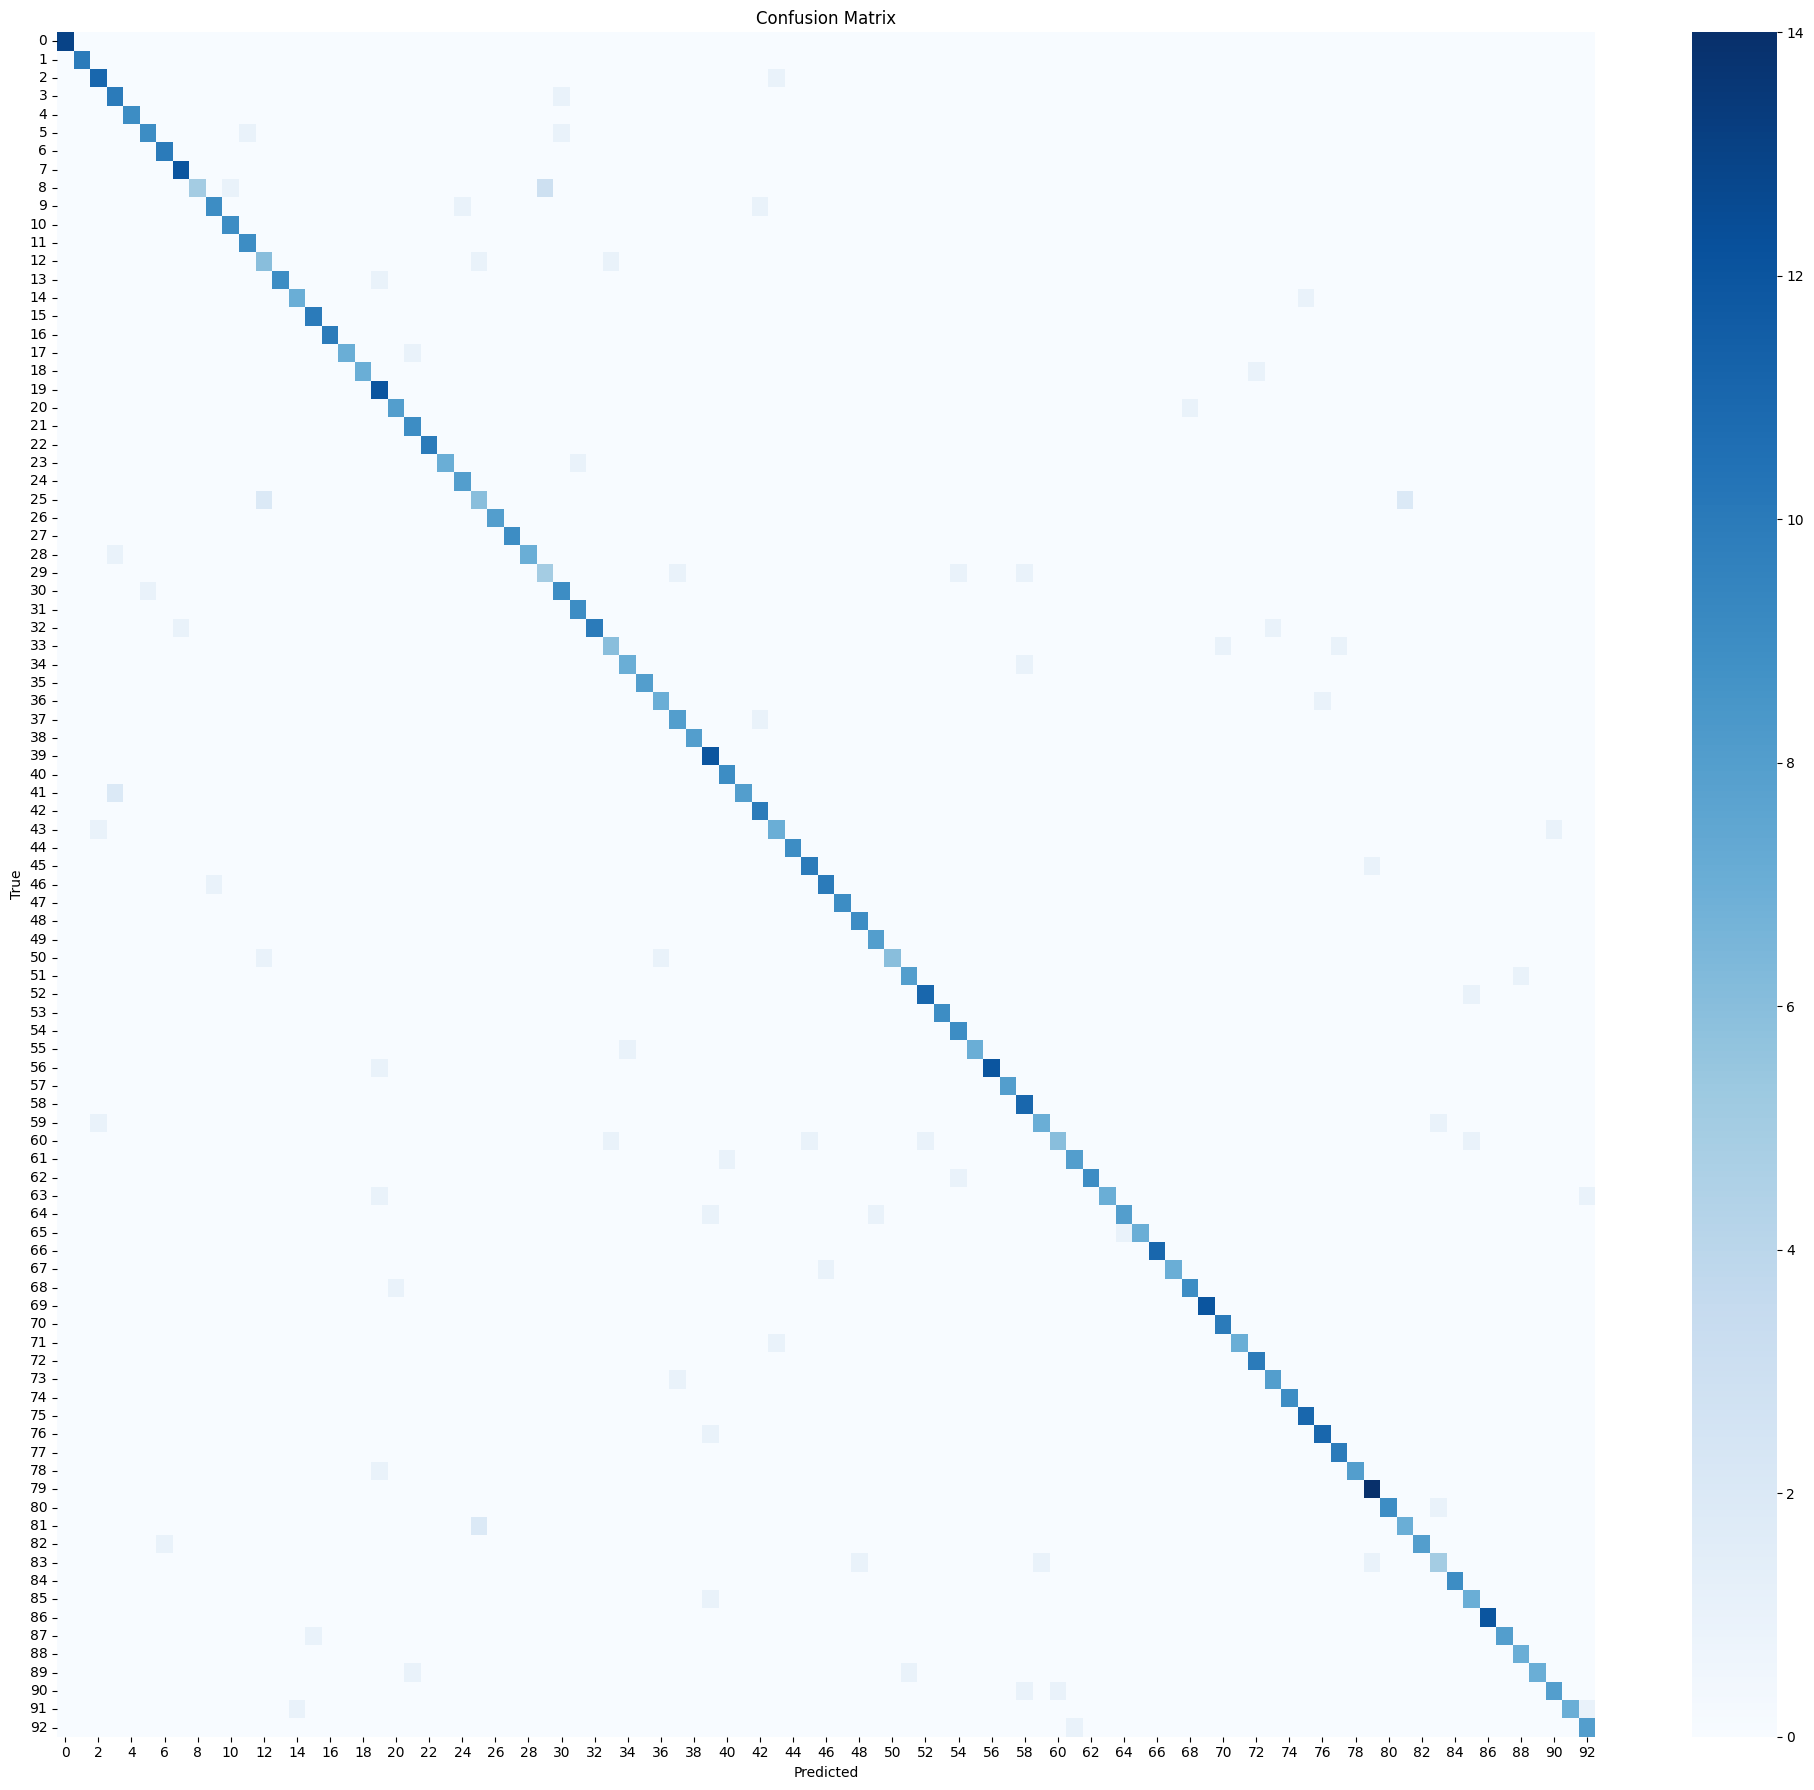

In [22]:
# Confusion Matrix (simplified for 93 classes)
cm = confusion_matrix(labels, predictions)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_PATH, 'confusion_matrix.png'), dpi=150)
plt.show()

In [23]:
# Find worst performing classes
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    labels, predictions, zero_division=0
)

# Sort by F1 score
class_performance = [(class_names[i], f1[i], support[i])
                     for i in range(num_classes)]
class_performance.sort(key=lambda x: x[1])

print("\nWorst Performing Classes (by F1 Score):")
print("-" * 50)
for name, f1_score, n_samples in class_performance[:10]:
    print(f"{name}: F1={f1_score:.3f}, samples={n_samples}")


Worst Performing Classes (by F1 Score):
--------------------------------------------------
doberman: F1=0.625, samples=8
collie: F1=0.632, samples=10
standard_schnauzer: F1=0.667, samples=8
border_collie: F1=0.706, samples=8
newfoundland: F1=0.706, samples=10
black-and-tan_coonhound: F1=0.714, samples=9
flat-coated_retriever: F1=0.750, samples=8
irish_terrier: F1=0.778, samples=9
shetland_sheepdog: F1=0.778, samples=9
miniature_schnauzer: F1=0.824, samples=9


## 9. Prediction Function

In [24]:
def predict_image(image_path, model, transform, class_names, device):
    """Predict breed for a single image."""
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = probabilities.max(1)

    return class_names[predicted.item()], confidence.item() * 100

print("Prediction function defined")

Prediction function defined


---

# ResNet50 Full Training (For Powerful GPU)

This section is for training ResNet50 from scratch with full model fine-tuning.
Recommended for GPUs with 16GB+ VRAM.

In [25]:
# Configuration for full training
FULL_TRAINING = False  # Set to True to run this section

if FULL_TRAINING:
    print("Starting ResNet50 Full Training Mode")
    print("This requires a powerful GPU!")

    # Reset seed
    set_seed(42)

    # Create fresh model with all layers trainable
    model_full = create_resnet50_model(num_classes, freeze_backbone=False)
    model_full = model_full.to(device)

    # Optimizer with discriminative learning rates
    optimizer_full = optim.AdamW([
        {'params': model_full.conv1.parameters(), 'lr': 1e-5},
        {'params': model_full.bn1.parameters(), 'lr': 1e-5},
        {'params': model_full.layer1.parameters(), 'lr': 5e-5},
        {'params': model_full.layer2.parameters(), 'lr': 1e-4},
        {'params': model_full.layer3.parameters(), 'lr': 2e-4},
        {'params': model_full.layer4.parameters(), 'lr': 5e-4},
        {'params': model_full.fc.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)

    scheduler_full = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_full, T_max=30, eta_min=1e-6
    )

    # Larger batch size if GPU allows
    batch_size_full = 64
    trainloader_full = DataLoader(trainset, batch_size=batch_size_full,
                                  shuffle=True, num_workers=4,
                                  pin_memory=True, drop_last=True)

    num_epochs_full = 30
    checkpoint_full = os.path.join(CHECKPOINT_PATH, 'resnet50_full_best.pth')

    print(f"Batch size: {batch_size_full}")
    print(f"Epochs: {num_epochs_full}")
    print(f"Total trainable params: {sum(p.numel() for p in model_full.parameters() if p.requires_grad):,}")

In [26]:
# Run full training
if FULL_TRAINING:
    history_full = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc_full = 0.0

    for epoch in range(num_epochs_full):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model_full, trainloader_full,
                                            criterion, optimizer_full, device)
        val_loss, val_acc = validate(model_full, valloader, criterion, device)

        scheduler_full.step()

        history_full['train_loss'].append(train_loss)
        history_full['train_acc'].append(train_acc)
        history_full['val_loss'].append(val_loss)
        history_full['val_acc'].append(val_acc)

        if val_acc > best_val_acc_full:
            best_val_acc_full = val_acc
            torch.save(model_full.state_dict(), checkpoint_full)

        elapsed = time.time() - start_time
        current_lr = optimizer_full.param_groups[-1]['lr']
        print(f"Epoch {epoch+1}/{num_epochs_full} | "
              f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f} | Time: {elapsed:.1f}s")

    print(f"\nBest Validation Accuracy: {best_val_acc_full:.2f}%")

    # Evaluate on test set
    model_full.load_state_dict(torch.load(checkpoint_full))
    test_loss_full, test_acc_full, _, _ = evaluate_model(
        model_full, testloader, criterion, device, class_names
    )
    print(f"Test Accuracy (Full Training): {test_acc_full:.2f}%")

## Summary

This notebook implemented dog breed classification using transfer learning with ResNet50.

**Key Techniques:**
- Two-phase training (frozen then fine-tuned)
- Data augmentation to prevent overfitting
- Learning rate scheduling
- Discriminative learning rates for fine-tuning

**Results:**
- Phase 1 (frozen backbone): See training output
- Phase 2 (fine-tuned): See training output
- Final test accuracy: See evaluation output

For detailed analysis and future improvements, see `dog_breed_classification_worklog.md`.